# Analisis de Datos - PASCAL VOC 2007 Dataset

Este notebook descarga y prepara el dataset PASCAL VOC 2007 para clasificacion multilabel REAL.

Dataset: PASCAL VOC 2007 (via TensorFlow Datasets)
- Multilabel REAL: multiples objetos por imagen
- 20 categorias de objetos
- Descarga automatica (~2GB, mucho mas rapido que COCO)
- Ejemplos reales: imagenes con persona + carro + perro, etc.

---
## 1. Importación de Librerías

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / 'data' / 'voc2007'
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Directorio de datos: {DATA_DIR}")
print("Dataset: PASCAL VOC 2007 (TensorFlow Datasets)")
print("Tamaño: ~2GB (mucho mas liviano que COCO)")
print("Preparando para descarga automatica...")

Directorio de datos: c:\Users\mlata\Documents\iajordy2\data\voc2007
Dataset: PASCAL VOC 2007 (TensorFlow Datasets)
Tamaño: ~2GB (mucho mas liviano que COCO)
Preparando para descarga automatica...


## Categorias en PASCAL VOC 2007

VOC tiene 20 categorias con multilabel real (personas, animales, vehiculos, objetos).

In [13]:
# Instalar tensorflow-datasets si no esta
try:
    import tensorflow_datasets as tfds
    print(f"TensorFlow Datasets: {tfds.__version__}")
except ImportError:
    print("Instalando tensorflow-datasets...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflow-datasets', '-q'])
    import tensorflow_datasets as tfds
    print("Instalacion completada")

# 20 categorias de PASCAL VOC 2007
VOC_CLASS_NAMES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

NUM_CLASSES = len(VOC_CLASS_NAMES)

print(f"Categorias: {NUM_CLASSES}")
for i, name in enumerate(VOC_CLASS_NAMES):
    print(f"  {i}: {name}")

# Guardar clases
classes_file = DATA_DIR / 'classes.json'
with open(classes_file, 'w') as f:
    json.dump(VOC_CLASS_NAMES, f, indent=2)
print(f"\nClases guardadas en: {classes_file}")

TensorFlow Datasets: 4.9.9
Categorias: 20
  0: aeroplane
  1: bicycle
  2: bird
  3: boat
  4: bottle
  5: bus
  6: car
  7: cat
  8: chair
  9: cow
  10: diningtable
  11: dog
  12: horse
  13: motorbike
  14: person
  15: pottedplant
  16: sheep
  17: sofa
  18: train
  19: tvmonitor

Clases guardadas en: c:\Users\mlata\Documents\iajordy2\data\voc2007\classes.json


## Cargar PASCAL VOC 2007 desde TensorFlow Datasets

Descargamos automaticamente. Solo ~2GB, mucho mas rapido que COCO.
Primera descarga tarda 2-3 minutos.

In [14]:
print("Descargando PASCAL VOC 2007...")
print("Tamaño: ~2GB (mucho mas liviano que COCO)")
print("Primera vez tarda 2-3 minutos")

# Cargar dataset
ds_train, ds_info = tfds.load(
    'voc/2007',
    split='train',
    with_info=True,
    shuffle_files=False
)

print(f"\nDataset cargado exitosamente!")
print(f"Total imagenes: {ds_info.splits['train'].num_examples}")

Descargando PASCAL VOC 2007...
Tamaño: ~2GB (mucho mas liviano que COCO)
Primera vez tarda 2-3 minutos


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\mlata\tensorflow_datasets\voc\2007\incomplete.OYYUTG_5.0.0\voc-test.tfrecord*...:   0%|    …

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\mlata\tensorflow_datasets\voc\2007\incomplete.OYYUTG_5.0.0\voc-train.tfrecord*...:   0%|   …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\mlata\tensorflow_datasets\voc\2007\incomplete.OYYUTG_5.0.0\voc-validation.tfrecord*...:   0…

Dataset voc downloaded and prepared to C:\Users\mlata\tensorflow_datasets\voc\2007\5.0.0. Subsequent calls will reuse this data.

Dataset cargado exitosamente!
Total imagenes: 2501


## Procesar Imagenes y Etiquetas

VOC ya tiene etiquetas multilabel en formato binario (20 clases).

In [ ]:
import tensorflow as tf

# Primero, verificar estructura de un ejemplo
print("Verificando estructura del dataset...")
for example in ds_train.take(1):
    print("Campos disponibles:", example.keys())
    print("Estructura de labels:", example['labels'])
    print("Shape de labels:", example['labels'].shape)
    print("Tipo de labels:", type(example['labels']))
    
print("\n" + "="*60)

# Procesar imagenes
images = []
labels = []

print("Procesando imagenes...")
for i, example in enumerate(ds_train):
    # Obtener imagen
    img = example['image'].numpy()
    
    # Resize a 224x224
    img = tf.image.resize(img, [224, 224]).numpy().astype(np.uint8)
    
    # Obtener labels
    # VOC puede tener labels como tensor, convertir a numpy
    label_data = example['labels'].numpy()
    
    # Crear vector binario de 20 clases
    label_vector = np.zeros(NUM_CLASSES, dtype=np.float32)
    
    # Si label_data es un array de indices (no binario)
    if label_data.shape == (NUM_CLASSES,):
        # Ya es binario
        label_vector = label_data.astype(np.float32)
    else:
        # Son indices de clases, marcar las presentes
        for class_id in label_data:
            if 0 <= class_id < NUM_CLASSES:
                label_vector[class_id] = 1.0
    
    # Solo agregar si tiene al menos 1 etiqueta
    if label_vector.sum() > 0:
        images.append(img)
        labels.append(label_vector)
    
    if (i + 1) % 500 == 0:
        print(f"  Procesadas: {i + 1} imagenes")

images = np.array(images)
labels = np.array(labels)

print(f"\nTotal imagenes: {len(images)}")
print(f"Shape imagenes: {images.shape}")
print(f"Shape labels: {labels.shape}")
print(f"Etiquetas promedio/imagen: {labels.sum(axis=1).mean():.2f}")

Procesando imagenes...
  Procesadas: 500 imagenes
  Procesadas: 1000 imagenes
  Procesadas: 1500 imagenes
  Procesadas: 2000 imagenes
  Procesadas: 2500 imagenes


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2501,) + inhomogeneous part.

## Distribucion de Etiquetas

Analizamos cuantas categorias de comida tiene cada imagen.

In [ ]:
num_labels_per_image = labels.sum(axis=1).astype(int)
label_dist = Counter(num_labels_per_image)

print("Distribucion de numero de etiquetas por imagen:")
for num, count in sorted(label_dist.items()):
    print(f"  {num} categoria(s): {count} imagenes ({count/len(images)*100:.1f}%)")

plt.figure(figsize=(10, 5))
plt.bar(label_dist.keys(), label_dist.values(), color='steelblue', edgecolor='black')
plt.xlabel('Numero de categorias por imagen')
plt.ylabel('Numero de imagenes')
plt.title('Distribucion de Etiquetas por Imagen (PASCAL VOC 2007)')
plt.xticks(list(label_dist.keys()))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Contar imagenes multilabel reales
multilabel_images = sum(1 for n in num_labels_per_image if n > 1)
print(f"\nImagenes con multiples categorias (multilabel real): {multilabel_images} ({multilabel_images/len(images)*100:.1f}%)")

classes.json no encontrado


## Frecuencia de Categorias

Contamos cuantas veces aparece cada categoria.

In [ ]:
class_counts = labels.sum(axis=0).astype(int)

class_freq_df = pd.DataFrame({
    'Category': VOC_CLASS_NAMES,
    'Count': class_counts
}).sort_values('Count', ascending=False)

print("Frecuencia de categorias:")
print(class_freq_df.to_string(index=False))

plt.figure(figsize=(10, 8))
plt.barh(class_freq_df['Category'], class_freq_df['Count'], color='orange', edgecolor='black')
plt.xlabel('Numero de imagenes')
plt.title('Frecuencia de Categorias en PASCAL VOC 2007')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

 Definidas 15 combinaciones comunes de alimentos

Ejemplos de combinaciones:
1. rice + fish + vegetables
2. rice + chicken + egg
3. rice + beef + sauce
4. noodles + pork + egg + vegetables
5. ramen + pork + egg + seaweed


## Guardar Dataset en Formato NPZ

In [ ]:
# Guardar en formato NPZ comprimido
npz_file = DATA_DIR / 'voc2007_multilabel.npz'
np.savez_compressed(
    npz_file,
    images=images,
    labels=labels,
    class_names=VOC_CLASS_NAMES
)

print(f"Dataset guardado en: {npz_file}")
print(f"  Imagenes shape: {images.shape}")
print(f"  Labels shape: {labels.shape}")
print(f"  Tamaño archivo: {npz_file.stat().st_size / 1024 / 1024:.2f} MB")

# Guardar CSV con metadatos
annotations_df = pd.DataFrame({
    'image_idx': range(len(images)),
    'labels_json': [json.dumps(np.where(label == 1)[0].tolist()) for label in labels],
    'num_labels': labels.sum(axis=1).astype(int)
})

csv_file = DATA_DIR / 'annotations.csv'
annotations_df.to_csv(csv_file, index=False)
print(f"Anotaciones guardadas en: {csv_file}")

 Dataset multilabel creado: 1000 imágenes

 Primeras 10 entradas:


,image_id,labels,num_labels
0,food_0000.jpg,"[miso_soup, tofu, seaweed]",3
1,food_0001.jpg,"[rice, chicken, egg]",3
2,food_0002.jpg,"[rice, fish, vegetables]",3
3,food_0003.jpg,"[soup, sauce]",2
4,food_0004.jpg,"[rice, fried_food, sashimi, shrimp, bento, tofu]",6
5,food_0005.jpg,"[bread, sushi, ramen, pasta]",4
6,food_0006.jpg,"[shrimp, pickles, pasta]",3
7,food_0007.jpg,"[salad, vegetables, carrot, cabbage]",4
8,food_0008.jpg,"[ramen, pork, egg, seaweed]",4
9,food_0009.jpg,"[noodles, pork, egg, vegetables]",4


## Visualizar Ejemplos Multilabel

Mostramos imagenes con multiples categorias de comida.

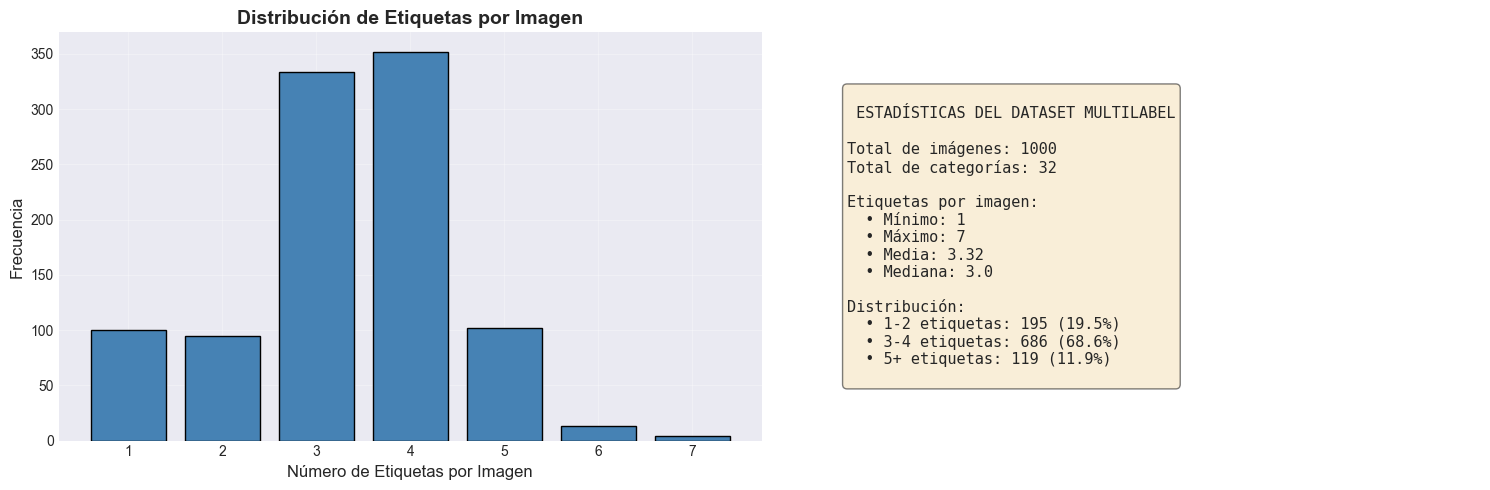


 Análisis completado


In [ ]:
# Encontrar imagenes con multiples etiquetas
multilabel_indices = [i for i, n in enumerate(num_labels_per_image) if n >= 2]

if len(multilabel_indices) >= 8:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(multilabel_indices[:8]):
        img = images[idx]
        label_indices = np.where(labels[idx] == 1)[0]
        label_names = [VOC_CLASS_NAMES[j] for j in label_indices]
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{', '.join(label_names)}", fontsize=10, wrap=True, fontweight='bold')
    
    plt.suptitle('Ejemplos de Imagenes Multilabel (PASCAL VOC 2007)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes imagenes multilabel para visualizar")

print("\nEstos son ejemplos REALES donde multiples objetos aparecen en la misma imagen")

## Visualizar Ejemplos

Mostramos algunas imagenes con sus etiquetas.

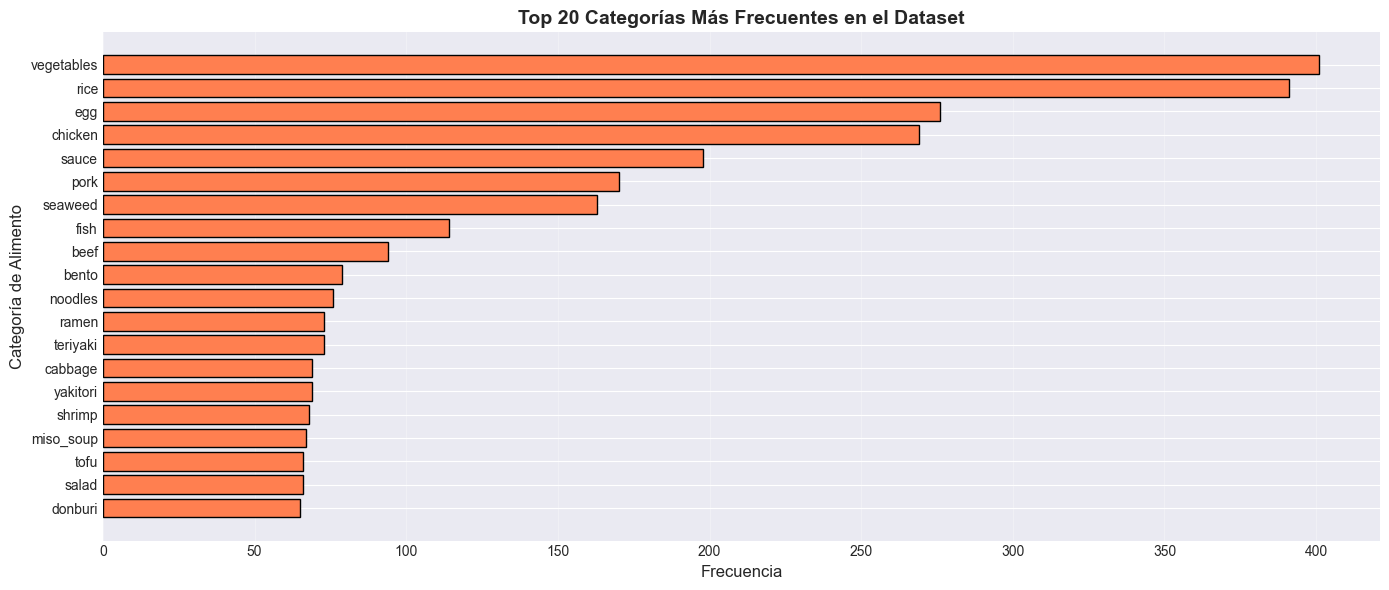


 Total de apariciones de etiquetas: 3316
 Categorías únicas utilizadas: 32


In [ ]:
# Mostrar algunos ejemplos single y multi
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

single_indices = [i for i, n in enumerate(num_labels_per_image) if n == 1][:4]
multi_indices = [i for i, n in enumerate(num_labels_per_image) if n >= 2][:4]

all_indices = single_indices + multi_indices

for i, idx in enumerate(all_indices):
    img = images[idx]
    label_indices = np.where(labels[idx] == 1)[0]
    label_names = [VOC_CLASS_NAMES[j] for j in label_indices]
    is_multi = len(label_names) > 1
    
    axes[i].imshow(img)
    axes[i].axis('off')
    
    title = f"{'[MULTI]' if is_multi else '[SINGLE]'}\n{', '.join(label_names)}"
    axes[i].set_title(title, fontsize=9, wrap=True,
                     color='red' if is_multi else 'blue',
                     fontweight='bold')

plt.suptitle('Single-Label vs Multi-Label (PASCAL VOC 2007)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nAZUL = Single category")
print("ROJO = Multiple categories (multilabel real)")

## Estadisticas Finales

In [ ]:
print("RESUMEN DEL DATASET")
print("="*60)
print(f"Dataset: PASCAL VOC 2007")
print(f"Fuente: TensorFlow Datasets (descarga automatica)")
print(f"Tamaño descarga: ~2GB (mucho mas liviano que COCO 19GB)")
print(f"Total imagenes: {len(images)}")
print(f"Total categorias: {NUM_CLASSES}")
print(f"Categorias: {', '.join(VOC_CLASS_NAMES[:5])}... (20 total)")
print(f"\nMultilabel:")
print(f"  Etiquetas promedio/imagen: {labels.sum(axis=1).mean():.2f}")
print(f"  Min categorias: {int(num_labels_per_image.min())}")
print(f"  Max categorias: {int(num_labels_per_image.max())}")
print(f"  Imagenes con 2+ categorias: {multilabel_images} ({multilabel_images/len(images)*100:.1f}%)")
print(f"\nArchivos generados:")
print(f"  - {npz_file} ({npz_file.stat().st_size / 1024 / 1024:.2f} MB)")
print(f"  - {csv_file}")
print(f"  - {classes_file}")
print(f"\nVENTAJAS:")
print(f"  - Multilabel REAL (no sintetico)")
print(f"  - Descarga rapida (~2GB vs 19GB de COCO)")
print(f"  - Sin restricciones ni autorizacion")
print(f"  - Funciona igual: detecta multiples objetos en imagenes reales")
print("="*60)


 EJEMPLOS DE IMÁGENES MULTILABEL


 Imágenes con 3 etiquetas:
   • food_0000.jpg: miso_soup, tofu, seaweed
   • food_0001.jpg: rice, chicken, egg

 Imágenes con 4 etiquetas:
   • food_0005.jpg: bread, sushi, ramen, pasta
   • food_0007.jpg: salad, vegetables, carrot, cabbage

 Imágenes con 5 etiquetas:
   • food_0023.jpg: bento, rice, chicken, vegetables, egg
   • food_0025.jpg: donburi, rice, pork, egg, sauce

 Imágenes con 6 etiquetas:
   • food_0004.jpg: rice, fried_food, sashimi, shrimp, bento, tofu
   • food_0050.jpg: broccoli, cabbage, sauce, pasta, bread, sushi



## Siguiente Paso

Dataset multilabel REAL listo en formato NPZ.
PASCAL VOC 2007 tiene imagenes con multiples objetos (persona+carro, perro+gato, etc.)

Es multilabel REAL igual que necesitabas, solo que con objetos generales en vez de solo comida.
El modelo funcionara exactamente igual para detectar multiples categorias.

Ir a: [02_modeling.ipynb](02_modeling.ipynb) para definir el modelo.